In [1]:
using ElectricGrid
using ControlSystemsBase
using PlotlyJS

In [2]:
CM = [0 1
    -1 0]
    
# Source
R = 1.1e-3
L = 70e-6
C = 250e-6

# Cable
C_b = 1e-4/2
L_b = x->1e-4
R_b = 1e-3

# Load
R_l = 100
C_l = 1e-2
L_l = 1e-2;

parameters = Dict()

grid_properties = Dict()
grid_properties["fs"] =  10e3
grid_properties["v_rms"] = 230
grid_properties["phase"] = 1;
parameters["grid"] = grid_properties

source1 = Dict()
source_list = []

# source1["fltr"] = "LC"
source1["fltr"] = "L"
source1["R1"] = R
source1["L1"] = L
# source1["C"] = C

push!(source_list, source1)

parameters["source"] = source_list

cable = Dict()
cable["R"] = R_b
cable["L"] = L_b
cable["C"] = C_b
cable_list = []

push!(cable_list, cable);
parameters["cable"] = cable_list

load1 = Dict()
load_list = []

load1["impedance"] = "RLC"
load1["R"] = R_l;
load1["L"] = L_l;
load1["C"] = C_l;

push!(load_list, load1);
parameters["load"] = load_list;

In [3]:
nc = NodeConstructor(num_sources=1, num_loads=1, parameters=parameters, CM=CM);

In [4]:
A, B, C, D = GetSystem(nc);
@show B

B = [14285.714285714286; 0.0; 0.0; 0.0; 0.0;;]


5×1 Matrix{Float64}:
 14285.714285714286
     0.0
     0.0
     0.0
     0.0

In [7]:
(rows, columns) = size(A)
AA = Matrix{Any}(undef, (rows, columns))
for row in 1:rows
    for column in 1:columns
        h = A[row, column]
        if isa(h, Number)
            AA[row, column] = x -> h
        else
            AA[row, column] = h
        end
    end
end

AAA(x) = (|>).(x, AA)

AAA([0, 0, 0, 0, 0])

5×5 Matrix{Real}:
   -15.7143  -14285.7       0            0           0
 40000.0          0    -40000.0          0           0
     0        10000.0     -10.0     -10000.0         0
     0            0        99.7506      -0.997506  -99.7506
     0            0         0          100.0         0

In [8]:
A′ = Float64.(AAA([0,0,1,0,3]))

5×5 Matrix{Float64}:
   -15.7143  -14285.7       0.0          0.0         0.0
 40000.0          0.0  -40000.0          0.0         0.0
     0.0      10000.0     -10.0     -10000.0         0.0
     0.0          0.0      99.7506      -0.997506  -99.7506
     0.0          0.0       0.0        100.0         0.0

In [9]:
ts = 1e-5
Ad = exp(A′*ts)
Bd = A′ \ (Ad - C) * B
sys_d = StateSpace(Ad, Bd, C, D, ts);
GetStateIds(nc)

5-element Vector{Any}:
 "source1_i_L1"
 "source1_v_C_cables"
 "cable1_i_L"
 "load1_v_C_total"
 "load1_i_L"

In [10]:
ns = length(A[1,:]) # get num of states
ni = length(B[1,:]) # get num of inputs
t = collect(0:ts:0.1)
x0 = [0.0 for i = 1:ns]
u = [250.0 for i = 1:length(t)]
uu = [u for i = 1:ni ]
uuu = mapreduce(permutedims, vcat, uu);

In [11]:
xout, _, _, _ = lsim(sys_d,uuu,t,x0=x0);

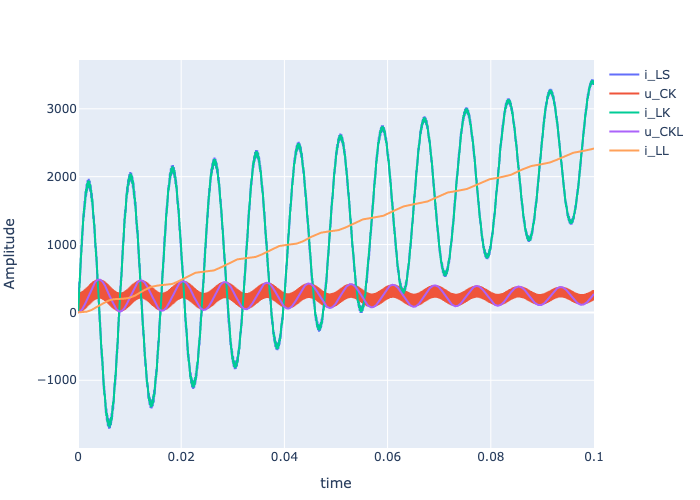

In [12]:
layout = Layout(xaxis_title="time", yaxis_title="Amplitude")
x_plot(i) = xout[i,:]
a = ["i_LS","u_CK","i_LK","u_CKL","i_LL"]
trace(i) = scatter(x=t, y=x_plot(i), mode="lines",name = "$(a[i])")

plot([trace(1),trace(2),trace(3),trace(4),trace(5)], layout)

In [19]:
M = Float64.([1,2,3])

3-element Vector{Float64}:
 1.0
 2.0
 3.0